(propensity_scores)=
# Bayesian propensity scores

:::{post} July, 2022
:tags: causal inference, quasi experimental design, regression, propensity scores, logistic regression
:category: intermediate
:author: Benjamin T. Vincent
:::

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc as pm
import seaborn as sns

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Introduction

Propensity scores are useful in quasi-experimental settings, where assignment of units to test or control groups were not random. Lack of [random assignment](https://en.wikipedia.org/wiki/Random_assignment) can be unavoidable in many situations:
- **Ethics:** it may not be ethically acceptible to randomly assign people to be exposed to some treatments, such as dry cleaning solvents, or living in close proximity to [fracking](https://en.wikipedia.org/wiki/Hydraulic_fracturing) operations.
- **Outside of your control:** it is not possible to randomly assign countries to [depart a large trading block](https://en.wikipedia.org/wiki/Brexit), nor is it always possible to randomly assign customers to an advertising exposure or no exposure groups.

Because of this non-random assignment, it is very likely that the test and control groups vary systematically. This makes a straight comparison between the outcome variable of interest problematic - are any differences in the outcome of interest due to the treatment or the other factors (aka [confounding variables](https://en.wikipedia.org/wiki/Confounding)) that influenced assignment to treatment or control conditions?

So how should we proceed? Should we give up in making any kind of statistical or causal claims about the effect of the treatment?  No! There are a range of things we can do, and this notebook focuses on the use of propensity scores.

In this notebook we will:
- Introduce a dataset alongside a the true causal DAG with counfounding variables.
- Show how the wrong causal model (ignoring confounders) will lead to wrong estimates of treatment effects
- Provide the motivation for calculating propensity scores with a fully worked out example. One of the key features of this notebooks is that it demonstrates how to go beyond calculating point estimaated, and calculates a posterior distribution over propensity scores.
- Provide a brief overview of the different ways you can use propensity scores to correct for the selection biases in our data, including:
  - Matching
  - Stratification
  - Covariate-adjustment
  - Inverse-probability weighting

## Data

This example is loosely based upon the excellent video [An intuitive introduction to Propensity Score Matching](https://www.youtube.com/watch?v=ACVyPp1Fy6Y) by Doug McKee.

In [3]:
df = pd.DataFrame(
    {
        "treatment": [1, 1, 1, 1, 0, 0, 0, 0, 0],
        "infant_mortality": [10, 15, 22, 19, 25, 19, 4, 8, 6],
        "docs_per_capita": [0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.04, 0.05, 0.04],
        "poverty_rate": [0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.1, 0.3, 0.2],
    }
)
df

,treatment,infant_mortality,docs_per_capita,poverty_rate
0,1,10,0.01,0.5
1,1,15,0.02,0.6
2,1,22,0.01,0.7
3,1,19,0.02,0.6
4,0,25,0.01,0.6
5,0,19,0.02,0.5
6,0,4,0.04,0.1
7,0,8,0.05,0.3
8,0,6,0.04,0.2


/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


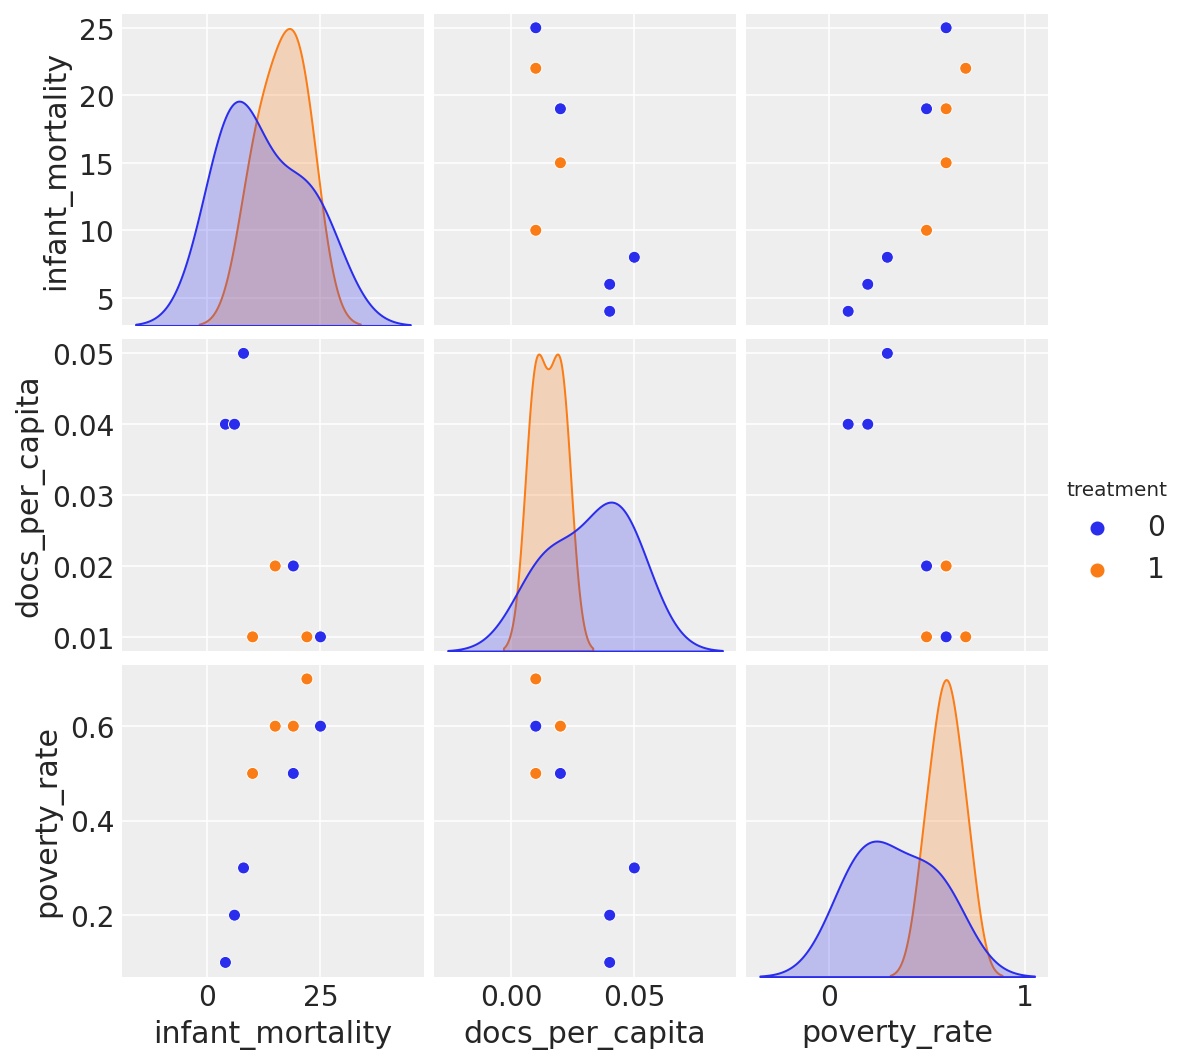

In [4]:
sns.pairplot(df, hue="treatment");

## Simple (wrong) causal explanation

The simplest approach we could take is to assume that infant mortality is causally influenced by the treatement, and the treatment alone. This causal DAG (see below) would suggest that we should simply look for differences in infant morality is different depending upon the treatment - so a simple linear model such as `infant_mortality ~ treatment`.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


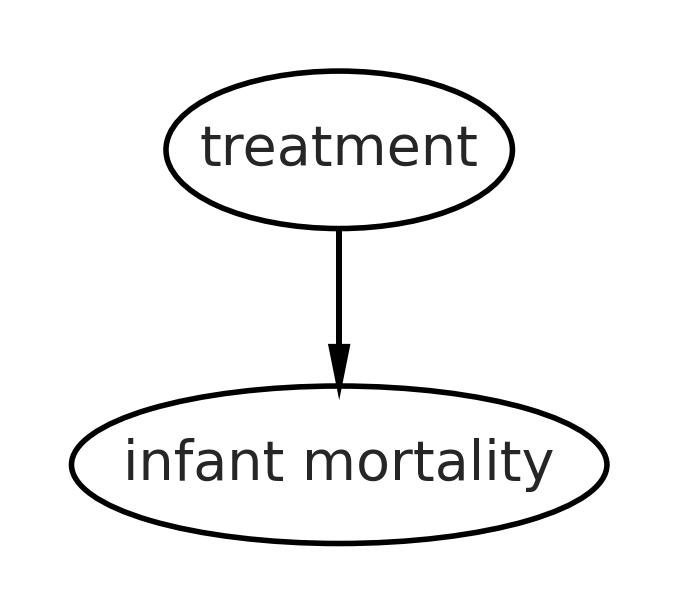

In [5]:
pgm = daft.PGM()
pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant mortality", 0, -1, aspect=3.4)
pgm.add_edge("t", "im")
pgm.render(dpi=200);

We could just look at the differences in infant mortality, split by treatment:

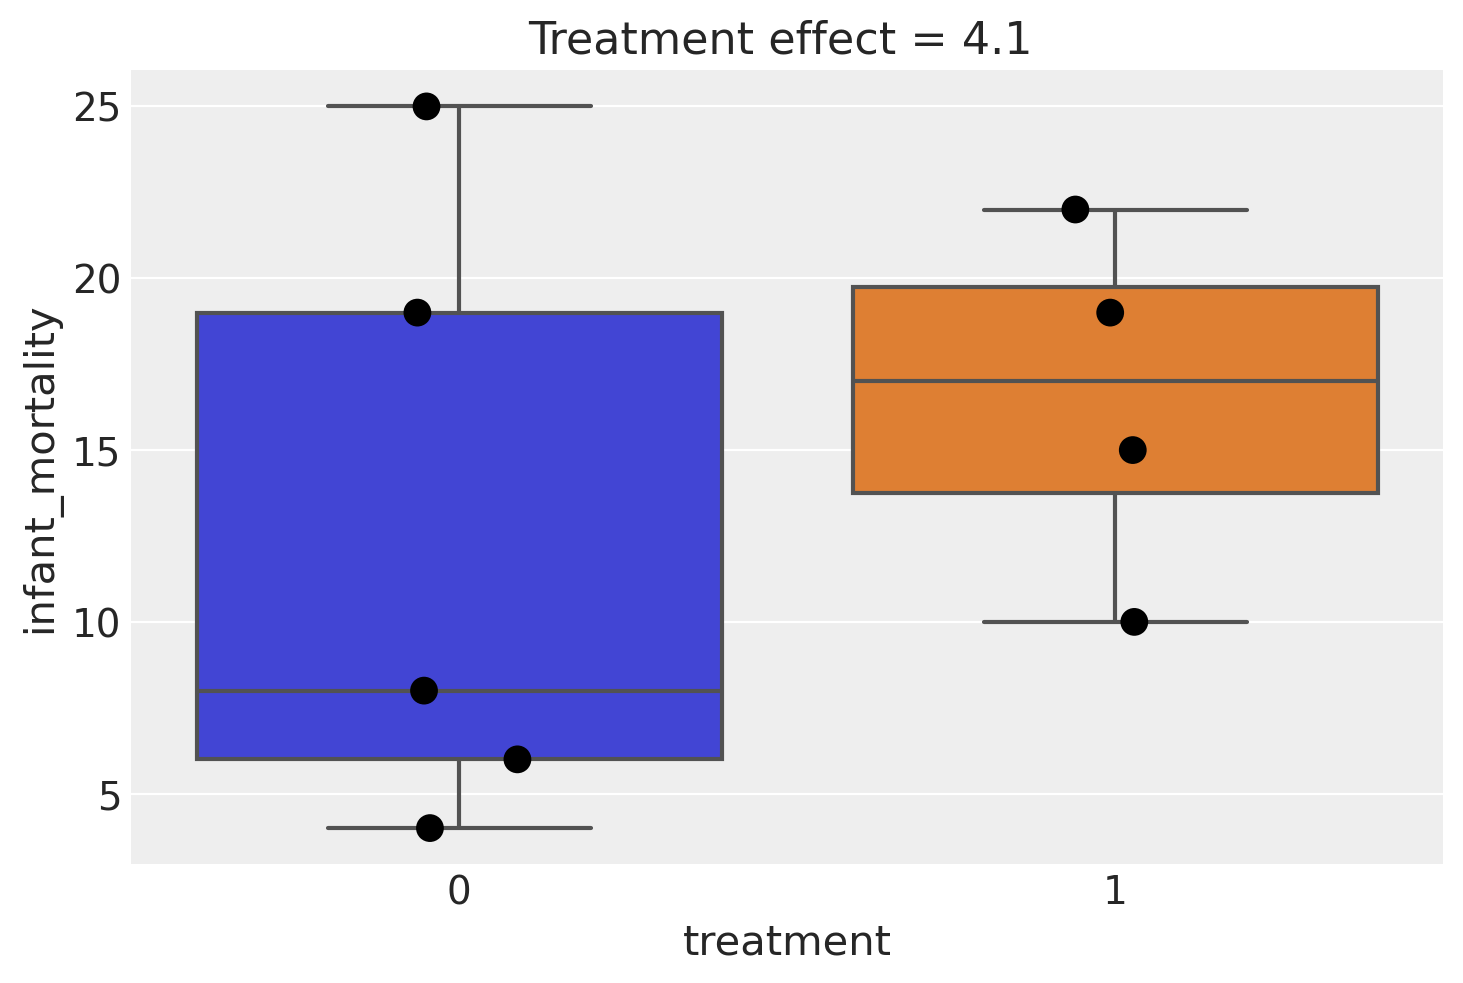

In [6]:
treatment_effect = np.mean(df["infant_mortality"][df["treatment"] == 1]) - np.mean(
    df["infant_mortality"][df["treatment"] == 0]
)

fig, ax = plt.subplots()

sns.boxplot(x="treatment", y="infant_mortality", data=df, ax=ax)

sns.stripplot(x="treatment", y="infant_mortality", data=df, size=10, color="k", ax=ax)

ax.set(title=f"Treatment effect = {treatment_effect:.1f} ");

So if this were the analysis we conducted then we would conclude that the treatment _increases_ infant mortality. And we would be flat out wrong!

Even if we calculated a posterior estimate of the treatment effect to obtain credible intervals, we would still be making the same fundamental mistake.

What else could we do?

If we had access to measures of infant mortality pre-treatment, then we could use a [differences in differences](https://en.wikipedia.org/wiki/Difference_in_differences) approach. But in this case, we do not have that data.

## Counfounders
Instead, we do have measures (conducted pre-treatment) of other properties of regions which may have influenced how they were assigned to the treatment or control condition.

We know in this case, our treatment was _not_ randomly assigned. Instead, we suspect through careful understanding of the particular problem, that regions with lower doctors per capita and higher poverty rates were more likely to be assigned to the treatment group. 

This would be in line with the heuristic of compassionate allocation of treatment to regions which needed it most. Although this would be statistically frustrating as it means we don't have random assignment.

All this means that our treatment and control groups are unequal in terms of their characteristics, as we can see in the plot below.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


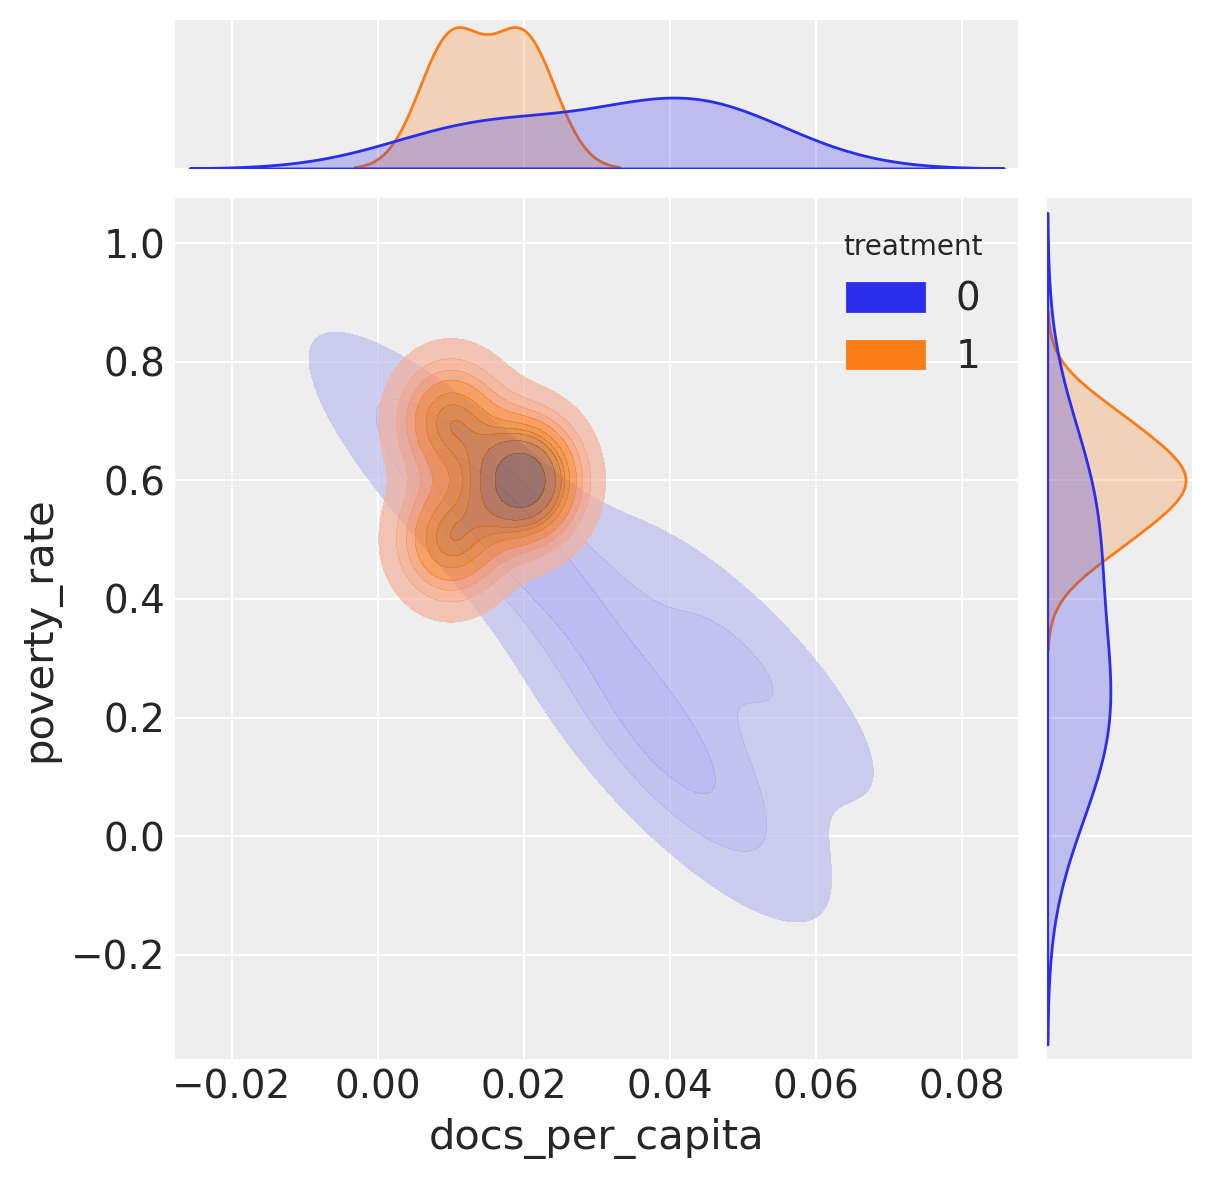

In [7]:
sns.jointplot(
    x="docs_per_capita",
    y="poverty_rate",
    hue="treatment",
    data=df,
    kind="kde",
    fill=True,
    alpha=0.7,
);

**NOTE:** If there was a sharp threshold in the characteristics of the regions being assigned to the treatment of control group, then we could consider analysing the data with the regression discontinuity design framework which we have covered here: {doc}`regression_discontinuity`.

## Improved causal explanation

We can however now refine our causal explanation of the data to incorporate these confounding variables. These can be summarised in the following DAG:

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


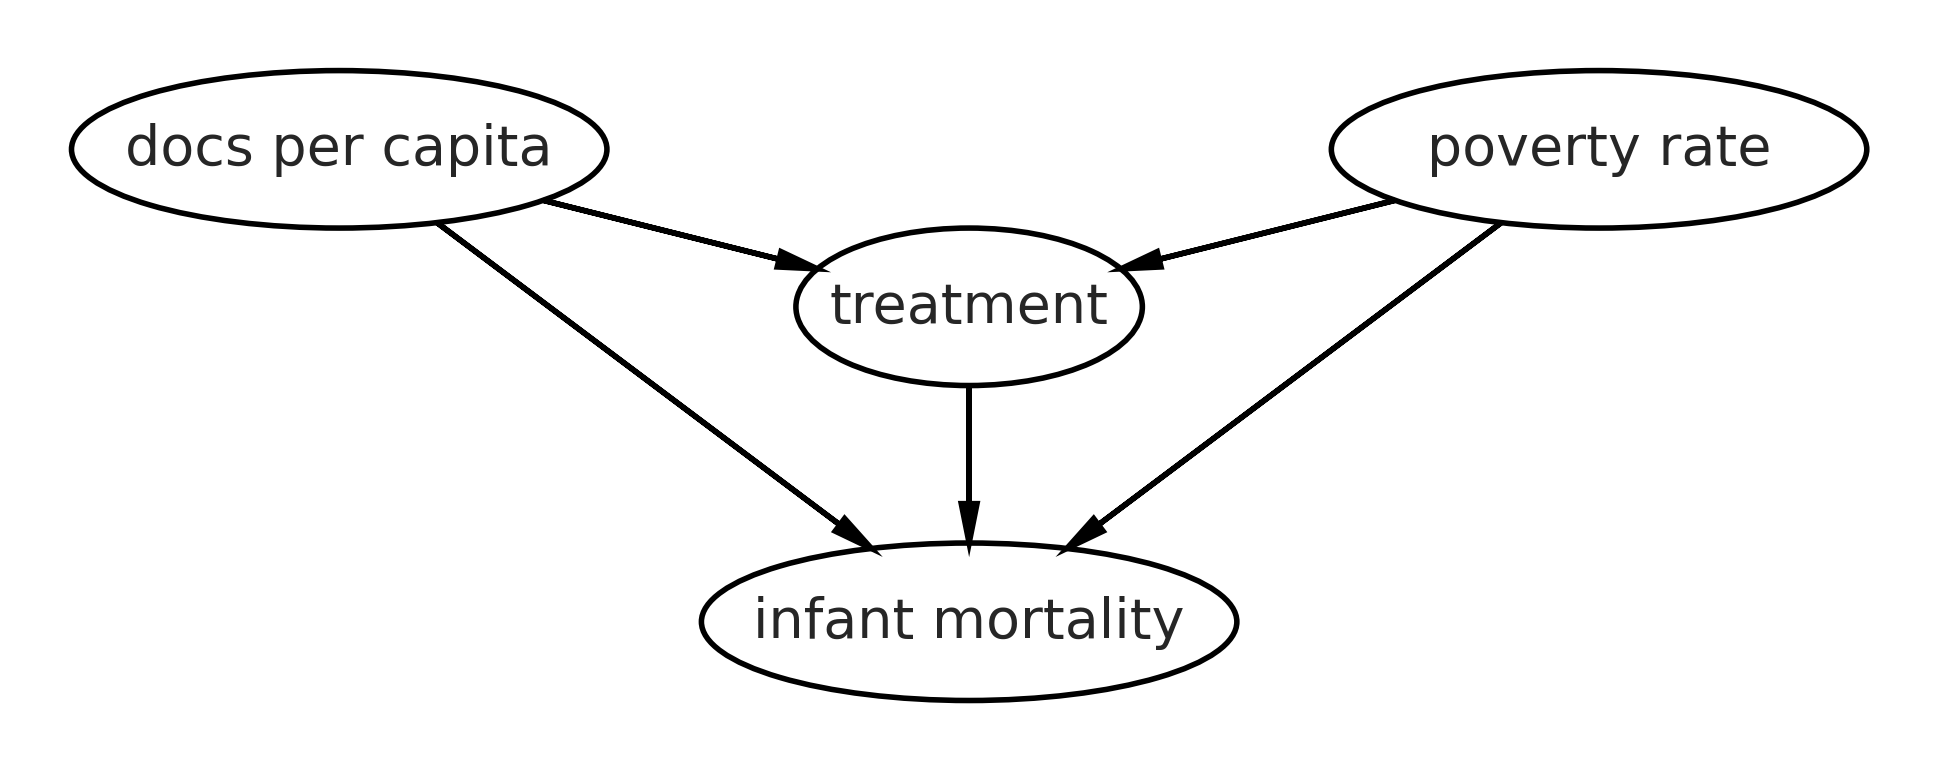

In [8]:
pgm = daft.PGM()

pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant mortality", 0, -1, aspect=3.4)
pgm.add_node("docs", "docs per capita", -2, 0.5, aspect=3.4)
pgm.add_node("pov", "poverty rate", 2, 0.5, aspect=3.4)

pgm.add_edge("t", "im")
pgm.add_edge("docs", "t")
pgm.add_edge("docs", "im")
pgm.add_edge("pov", "t")
pgm.add_edge("pov", "im")

pgm.render(dpi=200);

So in words what the DAG says is:
- exposure to treatment will causally inflence infant mortality
- but the number of doctors per captia causally influences both assignment to the treatment group and infant mortality levels
- and the poverty rate causally influences both the assignment to the treatment group and the infant mortality.

So we have doctors per capita and poverty rates confounding the treatment $\rightarrow$ infant mortality relationship.

There are different approaches we could take here, but our focus here is on propensity score matching.

## Calculate propensity score
In this section we will build a PyMC logistic regression model of the propensity. That is, the probability of inclusion in the treatment group.

In [9]:
y, X = patsy.dmatrices("treatment ~ docs_per_capita * poverty_rate", df)
labels = X.design_info.column_names
y, X = np.squeeze(np.asarray(y)), np.asarray(X)

COORDS = {"coeffs": labels, "obs": list(df.index)}

with pm.Model(coords=COORDS) as propensity_model:
    beta = pm.Normal("beta", 0, 1, dims="coeffs")
    propensity_score = pm.Deterministic(
        "propensity score", pm.math.invlogit(pm.math.dot(X, beta)), dims="obs"
    )
    pm.Bernoulli("infant_mortality", p=propensity_score, observed=y, dims="obs")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


We can optionally inspect the traces, but there are no sampling issues apparent.

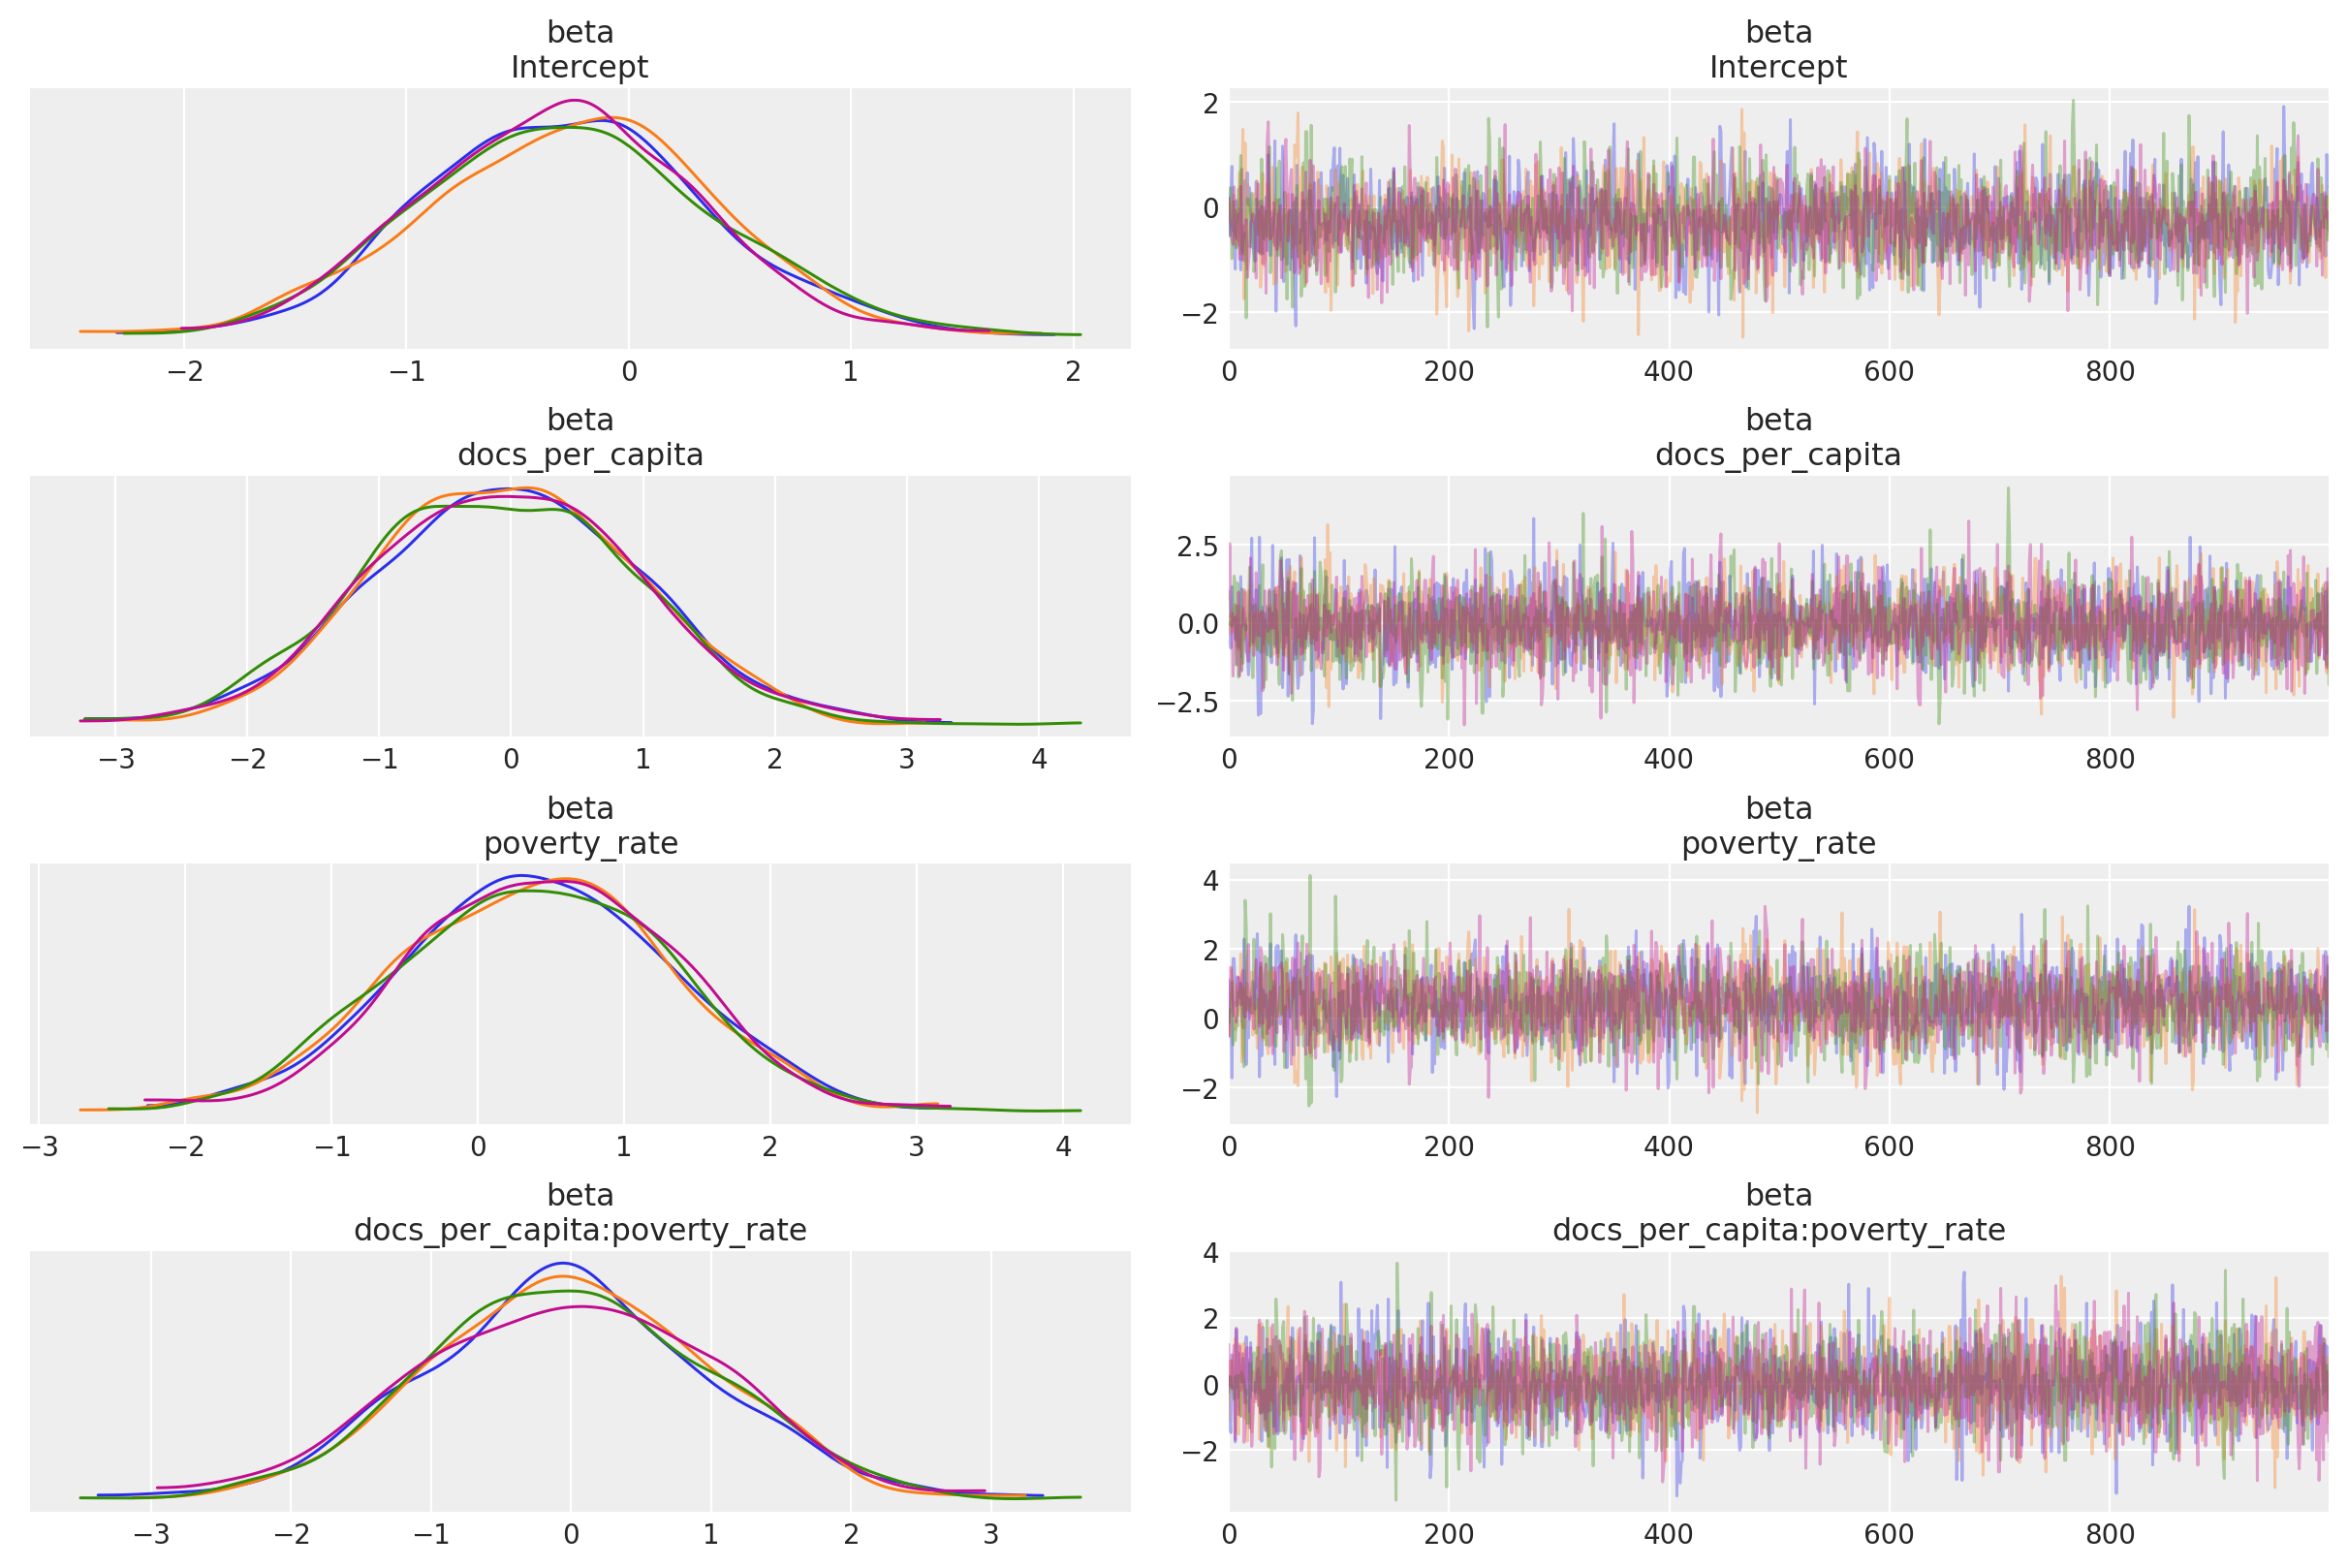

In [10]:
az.plot_trace(idata, compact=False, var_names="~propensity score");

And we can get a quick insight into the propensity scores by plotting the distribution of posterior mean propensity scores, split by treatment. This is good as there is some overlap in the propensity scores in both groups.

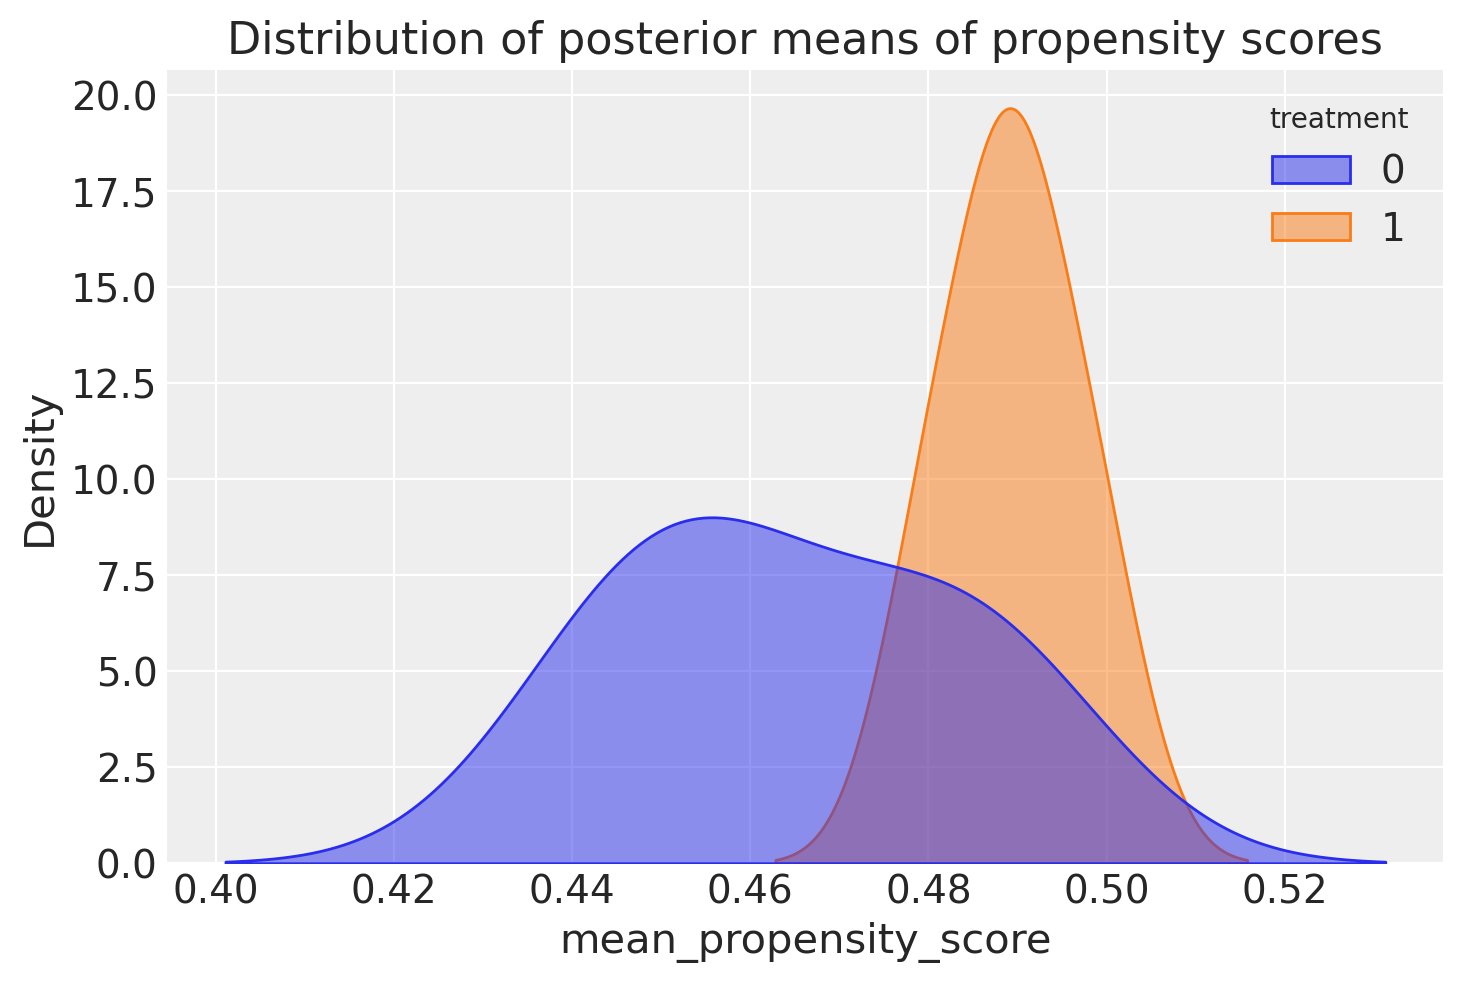

In [11]:
df["mean_propensity_score"] = idata.posterior["propensity score"].mean(
    dim=["chain", "draw"]
)

ax = sns.kdeplot(
    data=df,
    x="mean_propensity_score",
    hue="treatment",
    clip=(0, 1),
    fill=True,
    alpha=0.5,
)

ax.set(title="Distribution of posterior means of propensity scores");

## Matching

[Propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching)

The next step is to construct a "synthetic control group" with the following algorithm:

> for each unit in the treatment group, find a unit in the control group with the most similar propensity score.

The logic of this is that we are trying to build an artifical control group which is more similar to the treatment group in terms of the confounders than the raw control group.

There are many different algorithms used for matching, and some are best in different situations. We are going to pick one at random and go with finding the closest value and use sampling with replacement.

In [12]:
def find_nearest(array, value):
    # array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [13]:
def match(prop_treatment_list, prop_control_list):
    synth_control_idx = []
    for i, prop_treatment in enumerate(prop_treatment_list):
        # do the matching
        val, idx = find_nearest(prop_control_list, prop_treatment)
        synth_control_idx.append(idx)
    return synth_control_idx

In [14]:
# print(n_obs, n_samples)

# treatment_set = df['treatment']==1

In [15]:
# extract the MCMC samples of propensity scores
prop_scores = idata.posterior["propensity score"].stack(sample=["chain", "draw"]).data

# calculate quantities which are constant over samples
outcome_varname = "infant_mortality"
mean_of_treatment_group = np.mean(df[outcome_varname][df["treatment"] == 1])
treatment_set = df["treatment"] == 1
n_obs, n_samples = prop_scores.shape

treatment_effect = []

for sample in range(n_samples):
    # extract propensity scores for treatment and control units
    prop_treatment_list = prop_scores[treatment_set, sample]
    prop_control_list = prop_scores[~treatment_set, sample]

    # do propensity score matching
    synth_control_idx = match(prop_treatment_list, prop_control_list)

    # calculate the treatment effect between treatment and the matched control group
    synthetic_control_outcome_values = df.loc[synth_control_idx, outcome_varname]
    mean_of_matched_control_group = np.mean(synthetic_control_outcome_values)
    treatment_effect.append(mean_of_matched_control_group - mean_of_treatment_group)

treatment_effect = np.array(treatment_effect)

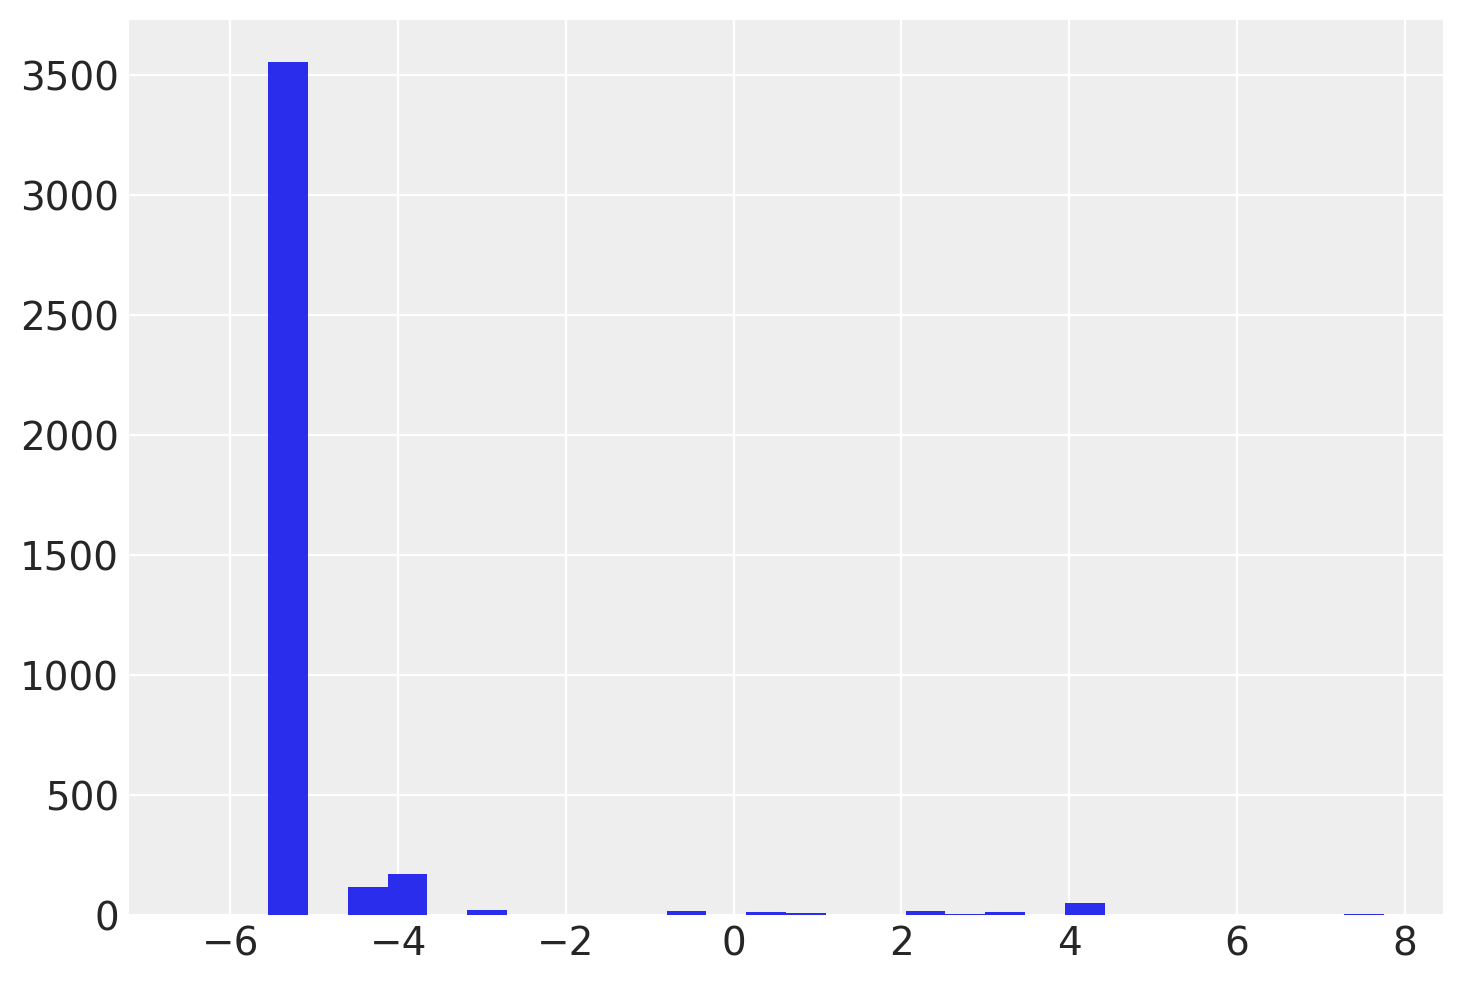

In [16]:
plt.hist(treatment_effect, bins=30);

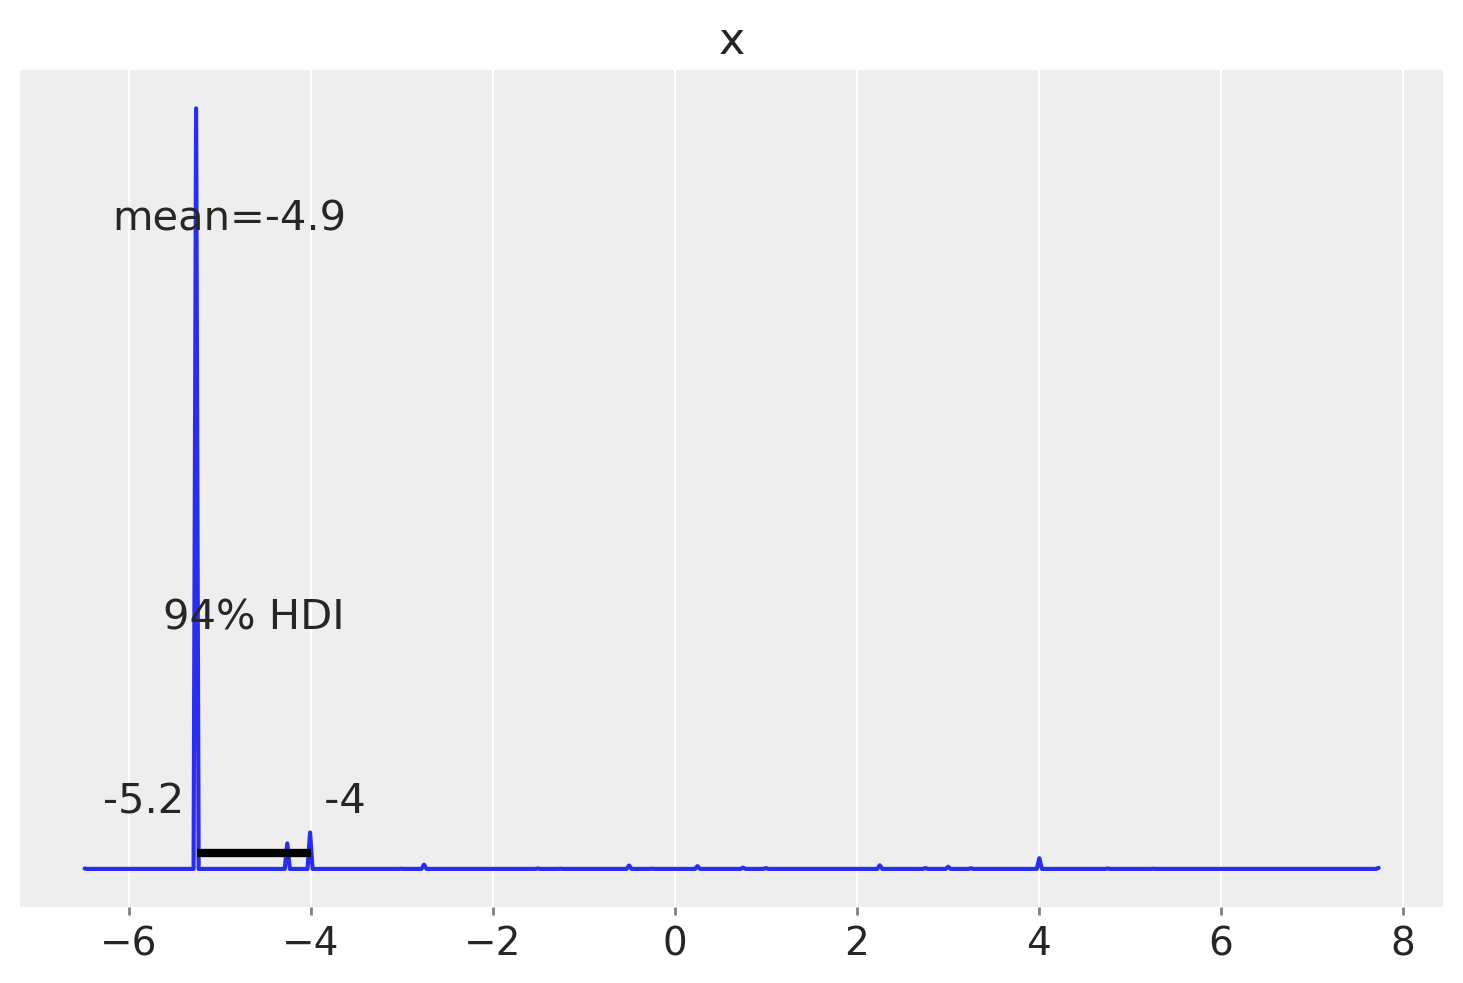

In [17]:
az.plot_posterior(treatment_effect);

## Stratification

## Covariate-adjustment

## Inverse-probability weighting

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2022.

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Tue Jul 19 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.7.3
aeppl : 0.0.31
xarray: 2022.3.0

daft      : 0.1.2
pymc      : 4.0.1
numpy     : 1.23.0
seaborn   : 0.11.2
arviz     : 0.12.1
patsy     : 0.5.2
pandas    : 1.4.3
matplotlib: 3.5.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::